In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil

if os.path.exists('/content/rock_scissor_paper/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/rock_scissor_paper/')
    print('/content/rock_scissor_paper/ is removed !!!')

In [3]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/rock_paper_scissors_classification/Data/YandG.zip','r') as target_file:
    target_file.extractall('/content/rock_scissor_paper/')

In [4]:
import os
from glob import glob

label_name_list = os.listdir('/content/rock_scissor_paper/')

print('total label nums = ', len(label_name_list))
print('==================================')
print(label_name_list)

total label nums =  3
['rock', 'scissor', 'paper']


# 작업폴더 생성

In [5]:
import os

if not os.path.exists('/content/modeling'):
    os.mkdir('/content/modeling')
    print('Modeling dir is created !')

Modeling dir is created !


# train 폴더로 copy

In [6]:
import shutil

src_root_dir = '/content/rock_scissor_paper/'
dst_root_dir = '/content/modeling/train'

if os.path.exists(dst_root_dir):
    os.rmdir(dst_root_dir)
    print(dst_root_dir + 'is deleted !')

shutil.copytree(src_root_dir, dst_root_dir)

'/content/modeling/train'

# test 폴더 생성 후 label 폴더 생성

In [7]:
import os

label_name_list = os.listdir('/content/modeling/train/')


if not os.path.exists('/content/modeling/test/'):
    os.mkdir('/content/modeling/test/')
    print('/content/modeling/test dir is created !')
    
    count = 0

    for label_name in label_name_list:
        os.mkdir('/content/modeling/test/' + label_name)
        count += 1

    print('train label count => ', count)

/content/modeling/test dir is created !
train label count =>  3


# train 데이터에서 test 데이터로 비율만큼 이동

In [8]:
import os
import shutil
import random
from glob import glob

ratio = 0.2

train_root_dir = '/content/modeling/train/'
test_root_dir = '/content/modeling/test/'

image_label_list = os.listdir(train_root_dir)

for label_name in image_label_list:
    
    train_image_list = glob(train_root_dir + label_name+'/*.jpg')

    print('========================================================================')
    print('total [%s] image file nums => [%s]'%(label_name, len(train_image_list)))
    
    split_num = int(ratio * len(train_image_list))

    print('split nums => ', split_num)

    test_image_list = train_image_list[0:split_num] 

    move_nums = 0

    for image_file in test_image_list:

        shutil.move(image_file, test_root_dir + label_name)
        
        move_nums += 1

    print('total move nums => ', move_nums)
    print('========================================================================')


total [rock] image file nums => [2537]
split nums =>  507
total move nums =>  507
total [scissor] image file nums => [2421]
split nums =>  484
total move nums =>  484
total [paper] image file nums => [2535]
split nums =>  507
total move nums =>  507


# 검증

In [9]:
src_root_dir = '/content/modeling/train'
dst_root_dir = '/content/modeling/test'

train_label_name_list = os.listdir(src_root_dir)
test_label_name_list = os.listdir(dst_root_dir)

train_label_name_list.sort()
test_label_name_list.sort()

if train_label_name_list != test_label_name_list:
  print('error !')
else:
  print(len(train_label_name_list),len(test_label_name_list))

for label_name in train_label_name_list:

  train_data_nums = len(os.listdir(os.path.join(src_root_dir,label_name)))
  test_data_nums = len(os.listdir(os.path.join(dst_root_dir,label_name)))

  print('[%s] | train => [%s], test => [%s], total => [%s]'%(label_name, train_data_nums, test_data_nums,train_data_nums+test_data_nums ))
  print('========================================================')

3 3
[paper] | train => [2028], test => [507], total => [2535]
[rock] | train => [2030], test => [507], total => [2537]
[scissor] | train => [1937], test => [484], total => [2421]


# Define Hyperparameter

In [10]:
IMG_WIDTH = 112
IMG_HEIGHT = 112
BATCH_SIZE = 32

In [11]:
train_dir = '/content/modeling/train'
test_dir = '/content/modeling/test'

# Image Data Generator 정의

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [13]:
train_data = train_data_gen.flow_from_directory(directory=train_dir,
                                  batch_size=BATCH_SIZE,
                                  color_mode='rgb',
                                  shuffle=True,
                                  target_size=(IMG_WIDTH,IMG_HEIGHT),
                                  class_mode='sparse')
test_data = test_data_gen.flow_from_directory(directory=test_dir,
                                  batch_size=BATCH_SIZE,
                                  color_mode='rgb',
                                  shuffle=True,
                                  target_size=(IMG_WIDTH,IMG_HEIGHT),
                                  class_mode='sparse')

print('==========train==========')
print(train_data.class_indices)
print(train_data.num_classes)
print(len(train_data.classes))

print('==========test==========')
print(test_data.class_indices)
print(test_data.num_classes)
print(len(test_data.classes))

Found 5995 images belonging to 3 classes.
Found 1498 images belonging to 3 classes.
==========train==========
{'paper': 0, 'rock': 1, 'scissor': 2}
3
5995
==========test==========
{'paper': 0, 'rock': 1, 'scissor': 2}
3
1498


In [14]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, ResNet50, InceptionV3, Xception

# MobileNet

In [15]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 56, 56, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [16]:
model = Sequential()

model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(2e-5),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 31,977,347
Trainable params: 31,924,227
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './rps_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist = model.fit(train_data,
                 epochs=10,
                 validation_data=test_data)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/10
188/188 [==============================] - 73s 294ms/step - loss: 0.4874 - acc: 0.8198 - val_loss: 2.5372 - val_acc: 0.3331
Epoch 2/10
188/188 [==============================] - 52s 276ms/step - loss: 0.1474 - acc: 0.9473 - val_loss: 5.9335 - val_acc: 0.3425
Epoch 3/10
188/188 [==============================] - 52s 275ms/step - loss: 0.0836 - acc: 0.9683 - val_loss: 1.5976 - val_acc: 0.3885
Epoch 4/10
188/188 [==============================] - 52s 275ms/step - loss: 0.0463 - acc: 0.9843 - val_loss: 1.1392 - val_acc: 0.6048
Epoch 5/10
188/188 [==============================] - 52s 274ms/step - loss: 0.0423 - acc: 0.9862 - val_loss: 0.1179 - val_acc: 0.9539
Epoch 6/10
188/188 [==============================] - 52s 275ms/step - loss: 0.0306 - acc: 0.9885 - val_loss: 0.0202 - val_acc: 0.9940
Epoch 7/10
188/188 [==============================] - 52s 275ms/step - loss: 0.0229 - acc: 0.9928 - val_loss: 0.0039 - val_acc: 0.9993
Epoch 8/10
188/188 [==============================] - 5

## Accuracy

In [18]:
model.evaluate(test_data)

47/47 [==============================] - 4s 83ms/step - loss: 0.0029 - acc: 0.9993


[0.0028906867373734713, 0.9993324279785156]

## Graph

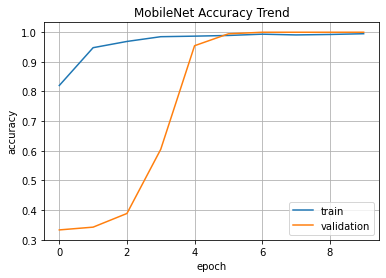

In [19]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('MobileNet Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

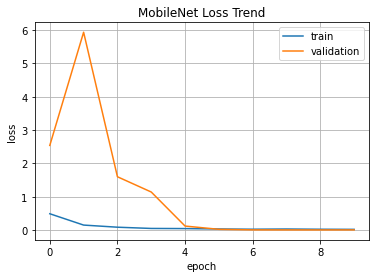

In [20]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('MobileNet Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [21]:
model.save('ResNet_112_acc_0.999.h5')

In [22]:
mv /content/ResNet_112_acc_0.999.h5 /content/drive/MyDrive